1. Data path는 내가 직접 입력하는 방향으로
2. Path를 입력하면 결과만 뽑아주는 형식으로
3. Breathhold, Education 등등에 대한 정보는 수작업으로 진행하는 걸로

In [38]:
import os, random
import numpy as np
import matplotlib.pyplot as plt

In [1]:
root = "E:/LIMITLESS_DL/Respiration/"
data_root = root + "DATA/"
results_root = root + "RESULTS/"

In [2]:
to_be_analyzed = "Mammo(Cho_0311)" # 내가 분석하고 싶은 데이터 폴더 이름
desired_datapath = data_root + to_be_analyzed + "/"
print(desired_datapath)

E:/LIMITLESS_DL/Respiration/DATA/Mammo(Cho_0311)/


In [19]:
patient_list = []
for item in sorted(os.listdir(desired_datapath)):
    curr_path = f"{desired_datapath}{item}/"
    if not os.path.isdir(curr_path): continue # 일반 폴더 이외에 고유한 확장자를 가지면 SKIP (README 같은 파일)
    patient_list.append(curr_path)

len(patient_list)

20

In [28]:
def read_field_data(fraction_path, field):
    filepath = f"{fraction_path}{os.listdir(fraction_path)[field-1]}"
    data_Times, data_Amps = [], []
    beam_Times, beam_States = [], []
    THICK_cnt, thin_cnt = 0, 0
    data_flag, beam_flag  = False, False

    with open(filepath, "r") as file: # Open file
        for line in file:
            if "=============" in line:
                THICK_cnt += 1
            if "-------------" in line:
                thin_cnt += 1
            
            ### Read time-data
            if (THICK_cnt >= 4) and (thin_cnt == 1):
                if data_flag and line == "\n": data_flag = False
                if data_flag:
                    time, amplitude = line.strip().split("\t")
                    data_Times.append(float(time))
                    data_Amps.append(float(amplitude))
                if (THICK_cnt >= 4 and thin_cnt <= 1) and ("Amplitude" in line): data_flag = True
            
            ### Read beam-data
            if (THICK_cnt >= 6):
                if beam_flag and line == "\n": break
                elif beam_flag:
                    time, state = line.strip().split("\t")
                    beam_Times.append(float(time))
                    beam_States.append(int(state))
                elif ("Time" in line): beam_flag = True

    return (data_Times, data_Amps), (beam_Times, beam_States)

# Data 잘 읽어오는지 확인

In [30]:
(data_Times, data_Amps), (beam_Times, beam_States) = read_field_data(f"{patient_list[0]}1/", 1)

print("Time(s)\tData(cm)")
print(f"{data_Times[0]}\t{data_Amps[0]}")
print(f"{data_Times[1]}\t{data_Amps[1]}")
print(f"{data_Times[2]}\t{data_Amps[2]}")
print("...\t...")
print("...\t...")
print(f"{data_Times[-3]}\t{data_Amps[-3]}")
print(f"{data_Times[-2]}\t{data_Amps[-2]}")
print(f"{data_Times[-1]}\t{data_Amps[-1]}")
print()
print("Time(s)\tBeam(cm)")
print(f"{beam_Times[0]}\t{beam_States[0]}")
print(f"{beam_Times[1]}\t{beam_States[1]}")

Time(s)	Data(cm)
0.0	0.887979521210001
0.015	0.889176296398458
0.03	0.890373071586914
...	...
...	...
44.88	-0.0690690128619309
44.895	-0.0731971298094543
44.91	-0.0773252467569797

Time(s)	Beam(cm)
0.0	1
4.75180371422502	0


In [39]:
def beam_modification(beam_Times):
    modified_beam_Times = []
    i = 0
    if len(beam_Times) <= 2: return beam_Times  # Only ONE beam-session
    else:
        modified_beam_Times.append(beam_Times[0])  # Fill in 1st ON-time
        while i < (len(beam_Times)//2-1):
            if (beam_Times[2*i+2] - beam_Times[2*i+1]) < 10:  # When patient failed to hold breath (mistake)
                i += 1
            else:
                modified_beam_Times.append(beam_Times[2*i+1])
                modified_beam_Times.append(beam_Times[2*i+2])
                i += 1
        modified_beam_Times.append(beam_Times[-1])
    return modified_beam_Times

def cut_by_beams(data_Times, data_Amps, beam_Times):
    dt = 0.015
    cutted_Amps = np.zeros(len(data_Amps))
    for i in range(len(beam_Times)//2):
        for j in range(len(data_Times)):
            if (data_Times[j] > beam_Times[2*i]):
                interval = int( (beam_Times[2*i+1] - beam_Times[2*i]) / dt )
                cutted_Amps[j:j+interval] = data_Amps[j:j+interval]
                break
    return cutted_Amps

def beam_enabling_intervals(data_Times, data_Amps, beam_Times):
    dt = 0.015
    total_intervals = []
    for i in range(len(beam_Times)//2):
        for j in range(len(data_Times)):
            if (data_Times[j] > beam_Times[2*i]):
                interval = int( (beam_Times[2*i+1] - beam_Times[2*i]) / dt )
                total_intervals.append(data_Amps[j:j+interval])
                break
    return total_intervals, len(total_intervals)

def regression_line(intv_Amps):
    dt = 0.015
    Times = [t*dt for t in range(len(intv_Amps))]
    slope, intercept = np.polyfit(Times, intv_Amps, deg=1)
    fitted_line = [slope*t+intercept for t in Times]
    return fitted_line

def dilate_metrics(data_Times, beam_Times, avg_lvls, fitted_lines):
    dilated_avgs = np.zeros(len(data_Times))
    dilated_line = np.zeros(len(data_Times))

    for i in range(len(beam_Times)//2):
        curr_avg = avg_lvls[i]
        curr_line = fitted_lines[i]
        for j in range(len(data_Times)):
            if (data_Times[j] > beam_Times[2*i]):
                dilated_avgs[j:j+len(curr_line)] = curr_avg * np.ones(len(curr_line))
                dilated_line[j:j+len(curr_line)] = curr_line
                break

    return dilated_avgs, dilated_line

(<Axes: title={'center': 'Beam-cutted data'}>,
 Text(0.5, 1.0, 'Beam-cutted data'))

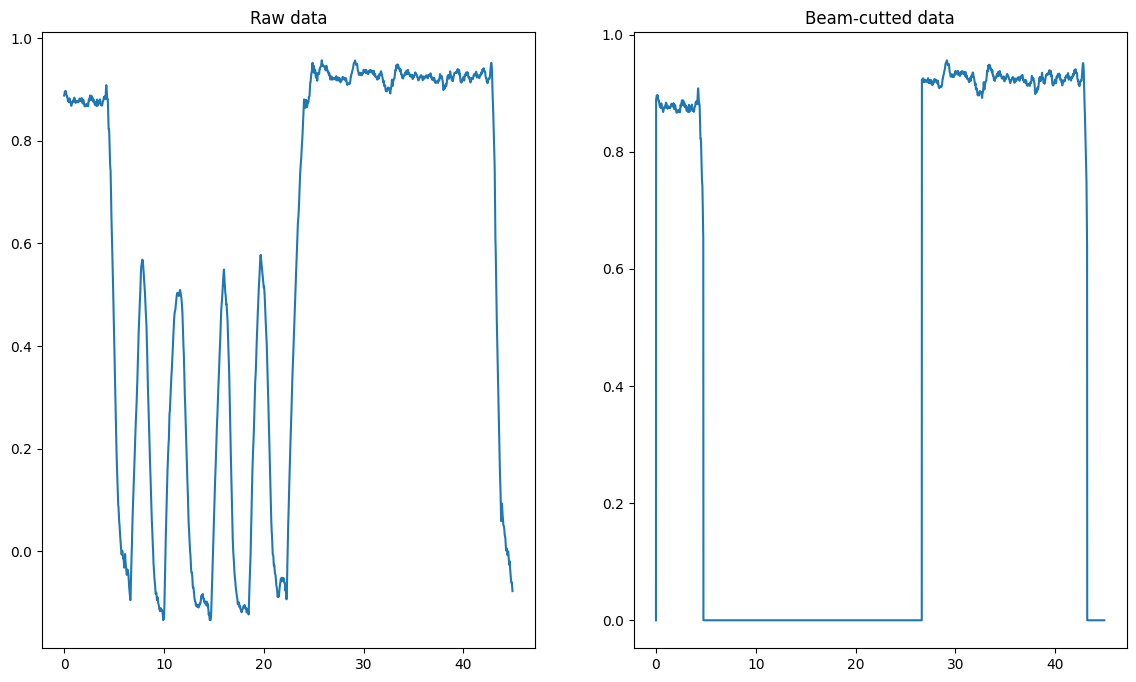

In [35]:
beam_Times = beam_modification(beam_Times)
cutted_Amps = cut_by_beams(data_Times, data_Amps, beam_Times)

plt.figure(figsize=(14,8))
plt.subplot(121), plt.plot(data_Times, data_Amps), plt.title("Raw data")
plt.subplot(122), plt.plot(data_Times, cutted_Amps), plt.title("Beam-cutted data")

In [37]:
enabled_intervals, num_intervals = beam_enabling_intervals(data_Times, data_Amps, beam_Times)

print(f"There are {num_intervals} beam-sessions.")

There are 2 beam-sessions.


([<matplotlib.lines.Line2D at 0x2bd7c063f50>],
 [<matplotlib.lines.Line2D at 0x2bd4c5ee250>])

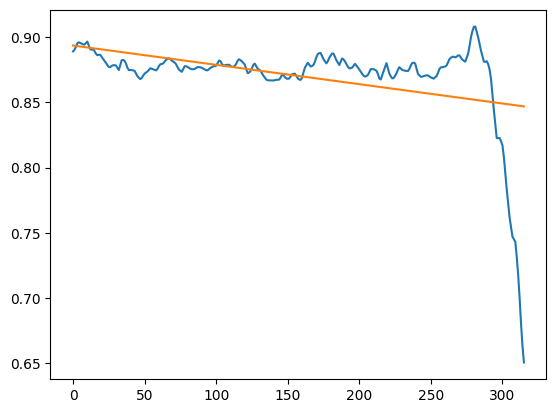

In [40]:
intervals = range(num_intervals)
sampled_interval = enabled_intervals[random.choice(intervals)]
fitted_line = regression_line(sampled_interval)

plt.plot(range(len(sampled_interval)), sampled_interval), plt.plot(range(len(sampled_interval)), fitted_line)

In [41]:
"""Reproducibility"""
# Average level per interval
def avg_lvl_per_interval(Amps):
    return np.sum(Amps) / len(Amps)

# Reproducibility (with a list of average levels)
def reproducibility(avg_levels):
    return max(avg_levels) - min(avg_levels)

# Average reproducibility
def mean_reproducibility(reprods):
    return np.mean(np.array(reprods))

"""Stability"""
# Vertical Error
def error_per_interval(Amps):
    dt = 0.015
    Times = [t*dt for t in range(len(Amps))]
    slope, _ = np.polyfit(Times, Amps, deg=1)
    duration = dt * ( len(Amps) - 1 )
    return abs(slope) * duration

# Stability (with a list of vertical distances)
def stability(errors):
    return max(errors)

# Average stability
def mean_stability(stabs):
    return np.mean(np.array(stabs))

"""Statistics"""
def coeff_var(total_metrics): # CV (coefficients of variation)
    """CV_intra & CV_inter"""
    mean = np.mean(total_metrics)
    std = np.std(total_metrics)
    return std / mean

In [43]:
average_level = avg_lvl_per_interval(sampled_interval)

print(f"Average level for current beam-session: {average_level}")

vertical_error = error_per_interval(sampled_interval)

print(f"Vertical error for current beam-session: {vertical_error}")

Average level for current beam-session: 0.8703370118056603
Vertical error for current beam-session: 0.04671355724202617


In [ ]:
def fraction_analysis(list_of_field_data):
    for fld_data in list_of_field_data:
        (data_Times, data_Amps), (beam_Times, beam_States) = read_field_data(fld_data)
        beam_Times = beam_modification(beam_Times)
        cutted_Amps = cut_by_beams(data_Times, data_Amps, beam_Times)
        enabled_intervals, num_intervals = beam_enabling_intervals(data_Times, data_Amps, beam_Times)
        field_levels, field_errors = 0, 0, 0
        for intv in range(num_intervals):
            average_level = avg_lvl_per_interval(enabled_intervals[intv])
            fitted_line = regression_line(enabled_intervals[intv])
            vertical_error = error_per_interval(enabled_intervals[intv])
            field_levels += average_level
            field_errors += vertical_error
        fx_level = field_levels / num_intervals
    return

In [ ]:
total_results = dict()
for patient_path in patient_list:
    curr_ID = patient_path.split("/")[-2]
    patient_results = []
    for fx in sorted(os.listdir(patient_path)):  # 20 fractions loop
        fx_path = f"{patient_path}{fx}/"
        total_data_per_fx = []
        for fld in sorted(os.listdir(fx_path)):  # Num of fields loop
            fld_data = f"{fx_path}{fld}"
            total_data_per_fx.append(fld_data)
        fx_result = fraction_analysis(total_data_per_fx) # Fraction 단위 분석 함수
        patient_results.append(fx_result)
    total_results[curr_ID] = patient_results